# Rolling Planning mit Lateness (Tardiness + Earliness)

In [2]:
max_time = 60*60*1 # 1h

In [3]:
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 26)

import utils.scheduling_solver as ssv
import utils.rescheduling_solver as rssv

import utils.presenter as show
import utils.checker as check


import utils.rolling_planning.init_jobs_times as rp_init
import utils.rolling_planning.procedure as rp_proced
import utils.schedule_deadline as deadline_gen

from ProductionDaySimulation import ProductionDaySimulation

In [4]:
file_template = "data/05_{text}.csv"

## Generierung des Datensatzes für 20 Tage (Ankunft)

In [6]:
days_numb = 20

In [7]:
df_instance = pd.read_csv("data/00_instance.csv")

df_ops, df_jobs = rp_init.init_jobs_with_arrivals(df_instance, days_numb,  u_b_mmax = 0.95)
df_ops

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
3795,Job_379,5,M9,76
3796,Job_379,6,M5,47
3797,Job_379,7,M3,52
3798,Job_379,8,M4,90


In [8]:
# a) Initialisierung der Deadlines
df_jobs = deadline_gen.get_times_df(df_ops, df_jobs, ssv.schedule_fcfs_with_arrivals, target_service=1.0)

# Rundung für CP 
df_jobs["Arrival"] = np.floor(df_jobs["Arrival"]).astype(int)
df_jobs["Deadline"] = np.ceil(df_jobs["Deadline"]).astype(int)
df_jobs.head()

,Job,Arrival,Deadline
0,Job_000,0,1171
1,Job_001,83,1595
2,Job_002,144,1828
3,Job_003,197,2138
4,Job_004,233,1398


In [9]:
# b) Bestimmung der "Ready Time"
df_jobs['Ready Time'] = ((df_jobs['Arrival'] // 1440) + 1) * 1440

# c) Processing Time
processing_time = df_ops.groupby('Job')['Processing Time'].sum()
df_jobs = pd.merge(df_jobs, processing_time, on='Job')

# d) Bestimmung des Slacks
df_jobs['Slack'] = df_jobs['Deadline'] - (df_jobs['Ready Time'] + df_jobs['Processing Time'])

# e) Anpassung der Deadlines
min_slack = df_jobs['Slack'].min()

if min_slack < 10:
    extra_time = abs(min_slack) + 10 if min_slack < 10 else 10
    print(f"Der bisherige min. Slack: {min_slack}")
    df_jobs["Deadline"] = df_jobs["Deadline"] + extra_time

# f) erneute Bestimmung des Slacks
df_jobs['Slack'] = df_jobs['Deadline'] - (df_jobs['Ready Time'] + df_jobs['Processing Time'])
df_jobs 

Der bisherige min. Slack: -664


,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1845,1440,395,10
1,Job_001,83,2269,1440,510,319
2,Job_002,144,2502,1440,568,494
3,Job_003,197,2812,1440,655,717
4,Job_004,233,2072,1440,393,239
...,...,...,...,...,...,...
375,Job_375,28488,31103,28800,655,1648
376,Job_376,28494,30333,28800,393,1140
377,Job_377,28495,30853,28800,568,1485
378,Job_378,28614,30459,28800,395,1264


In [10]:
file = file_template.format(text= "all_jobs")
df_jobs.to_csv(file, index = False)

file = file_template.format(text= "all_ops")
df_ops.to_csv(file, index = False)

### Params

In [12]:
day_length = 1440
day_numb = 0
day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 00: [0, 1440)


> Tag 0 wird nicht ausgeführt

## Tag 1 (init. Tag - kein Rescheduling)

In [15]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [16]:
# aktuelle Produktionaufträge
df_jobs_curr, df_ops_curr = rp_proced.filter_ops_and_jobs_by_ready_time(df_jobs, df_ops, ready_time = day_start)
df_jobs_curr

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1845,1440,395,10
1,Job_001,83,2269,1440,510,319
2,Job_002,144,2502,1440,568,494
3,Job_003,197,2812,1440,655,717
4,Job_004,233,2072,1440,393,239
5,Job_005,302,2447,1440,496,511
6,Job_006,340,2248,1440,416,392
7,Job_007,488,2760,1440,539,781
8,Job_008,708,3152,1440,597,1115
9,Job_009,740,3015,1440,540,1035


### A) Scheduling

In [18]:
starting_time = time.time()

# Scheduling
df_plan = ssv.solve_cp_jssp_lateness_by_tardiness_and_earliness(df_ops_curr, df_jobs_curr, w_t = 5,
                                                                schedule_start = 1440,
                                                                msg=False, timeLimit=max_time, gapRel= 0.00)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan


Solver-Status         : OPTIMAL
Objective Value       : 46.00
Best Objective Bound  : 46.00
Laufzeit              : 0.97 Sekunden

Scheduling-Dauer: 0 Minuten und 1.11 Sekunden.


,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_000,0,M0,0,1845,1440,29,1469,-376,0,376
1,Job_004,0,M2,233,2072,1440,14,1454,-618,0,618
2,Job_005,0,M2,302,2447,1454,84,1538,-909,0,909
3,Job_000,1,M1,0,1845,1469,78,1547,-298,0,298
4,Job_004,1,M0,233,2072,1469,6,1475,-597,0,597
...,...,...,...,...,...,...,...,...,...,...,...
185,Job_013,9,M7,1123,3267,3242,25,3267,0,0,0
186,Job_011,9,M8,894,3338,3264,74,3338,0,0,0
187,Job_016,9,M4,1135,3493,3460,33,3493,0,0,0
188,Job_018,9,M7,1354,3629,3584,45,3629,0,0,0


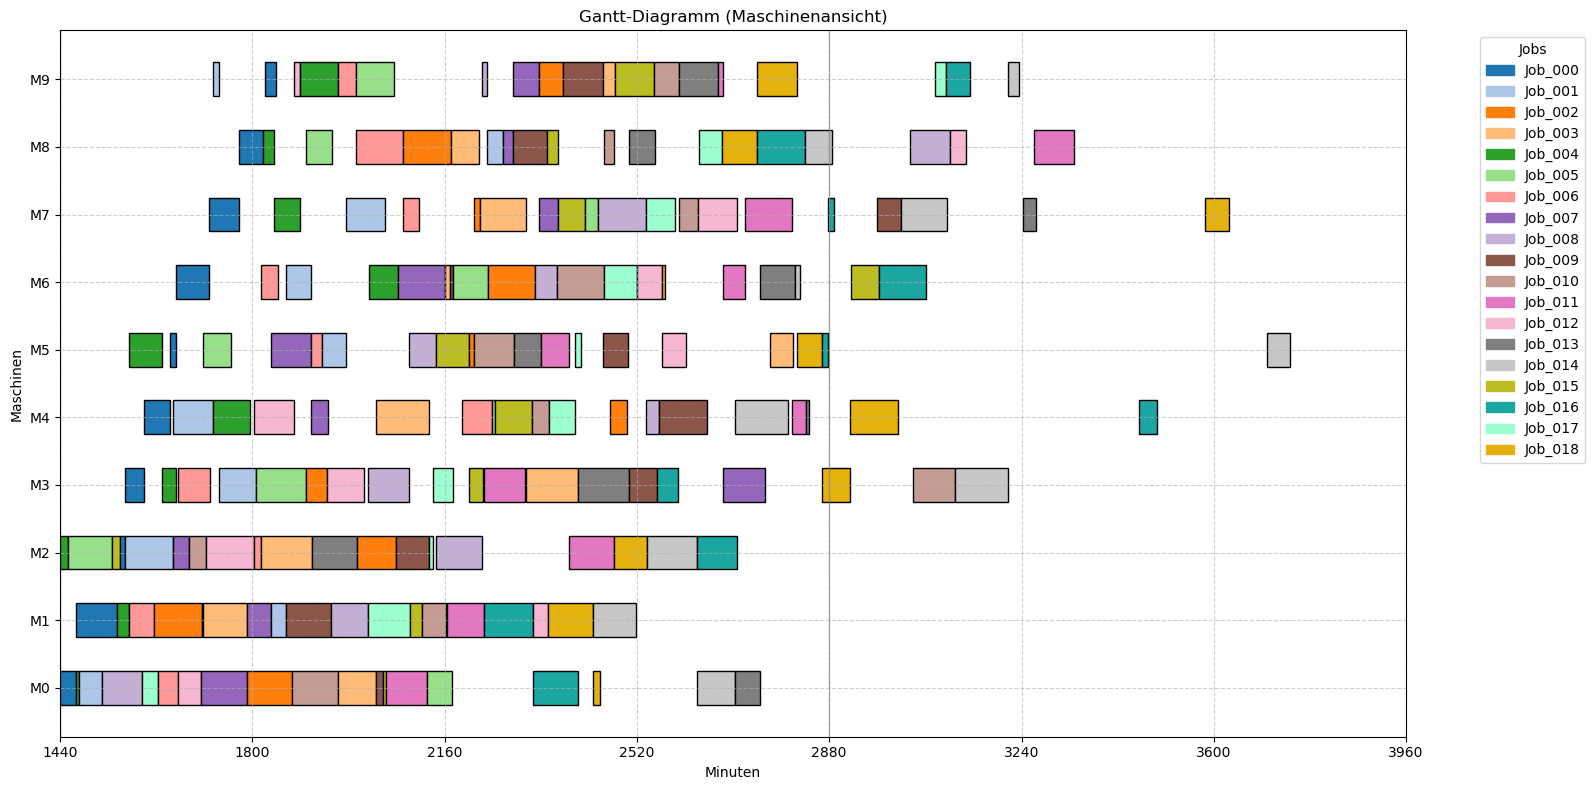

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [19]:
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [20]:
file = file_template.format(text= f"plan_{day_numb:02d}_init")
file

'data/05_plan_01_init.csv'

In [21]:
df_plan.to_csv(file, index = False)

### B) Aufteilung in heutige und zukünftge Operationen

In [23]:
df_plan_for_sim = rp_proced.filter_plan_for_today(df_plan, latest_op_start = day_end)
df_plan_for_sim

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_000,0,M0,0,1845,1440,29,1469,-376,0,376
1,Job_000,8,M8,0,1845,1775,44,1819,-26,0,26
2,Job_000,1,M1,0,1845,1469,78,1547,-298,0,298
3,Job_000,7,M7,0,1845,1719,56,1775,-70,0,70
4,Job_000,9,M9,0,1845,1824,21,1845,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
168,Job_018,2,M2,1354,3629,2477,61,2538,-1091,0,1091
169,Job_018,6,M5,1354,3629,2820,47,2867,-762,0,762
170,Job_018,1,M0,1354,3629,2438,13,2451,-1178,0,1178
171,Job_018,4,M8,1354,3629,2680,64,2744,-885,0,885


In [24]:
df_plan_waiting = rp_proced.filter_plan_for_future(df_plan, earliest_op_start = day_end)
df_plan_waiting

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_008,9,M8,708,3152,3032,74,3106,-46,0,46
1,Job_009,9,M7,740,3015,2970,45,3015,0,0,0
2,Job_010,9,M3,845,3116,3037,79,3116,0,0,0
3,Job_011,9,M8,894,3338,3264,74,3338,0,0,0
4,Job_012,9,M8,950,3136,3106,30,3136,0,0,0
5,Job_013,9,M7,1123,3267,3242,25,3267,0,0,0
6,Job_014,6,M7,1128,3743,3015,85,3100,-643,0,643
7,Job_014,7,M3,1128,3743,3116,98,3214,-529,0,529
8,Job_014,8,M9,1128,3743,3214,22,3236,-507,0,507
9,Job_014,9,M5,1128,3743,3700,43,3743,0,0,0


In [25]:
file = file_template.format(text= f"plan_{day_numb:02d}_waiting")
file

'data/05_plan_01_waiting.csv'

In [26]:
df_plan_waiting.to_csv(file, index = False)

### C) Simulation

In [28]:
simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.3)
df_execution, df_plan_undone = simulation.run(start_time = day_start, end_time=day_end)

[24:00:00] Job_000 started on M0
[24:00:00] Job_004 started on M2
[24:14:46] Job_000 finished on M0 (after 14 minutes 47 seconds)
[24:18:19] Job_004 finished on M2 (after 18 minutes 20 seconds)
[24:18:19] Job_005 started on M2
[24:29:00] Job_000 started on M1
[24:29:00] Job_004 started on M0
[24:37:25] Job_004 finished on M0 (after 08 minutes 26 seconds)
[24:37:25] Job_001 started on M0
[25:13:46] Job_001 finished on M0 (after 36 minutes 20 seconds)
[25:18:00] Job_008 started on M0
[25:46:25] Job_005 finished on M2 (after 88 minutes 06 seconds)
[25:46:25] Job_015 started on M2
[26:03:13] Job_015 finished on M2 (after 16 minutes 48 seconds)
[26:03:13] Job_001 started on M2
[26:11:27] Job_000 finished on M1 (after 102 minutes 28 seconds)
[26:11:27] Job_004 started on M1
[26:29:27] Job_008 finished on M0 (after 71 minutes 28 seconds)
[26:30:58] Job_004 finished on M1 (after 19 minutes 31 seconds)
[26:30:58] Job_006 started on M1
[26:30:58] Job_004 started on M5
[26:34:00] Job_017 started 

In [29]:
df_execution

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
0,Job_000,0,0,M0,1440.00,14.78,1454.78,1454.78
1,Job_000,1,0,M1,1469.00,102.46,1571.46,1571.46
2,Job_000,2,0,M2,1675.88,16.42,1692.30,1692.30
3,Job_000,3,0,M3,1726.87,32.42,1759.29,1759.29
4,Job_000,4,0,M4,1811.99,52.42,1864.41,1864.41
...,...,...,...,...,...,...,...,...
153,Job_018,1,1354,M0,2586.80,8.89,1241.69,2595.69
154,Job_018,2,1354,M2,2595.69,86.96,1328.65,2682.65
155,Job_018,3,1354,M6,2741.37,8.96,1396.33,2750.33
156,Job_018,4,1354,M8,2750.33,123.26,1519.59,2873.59


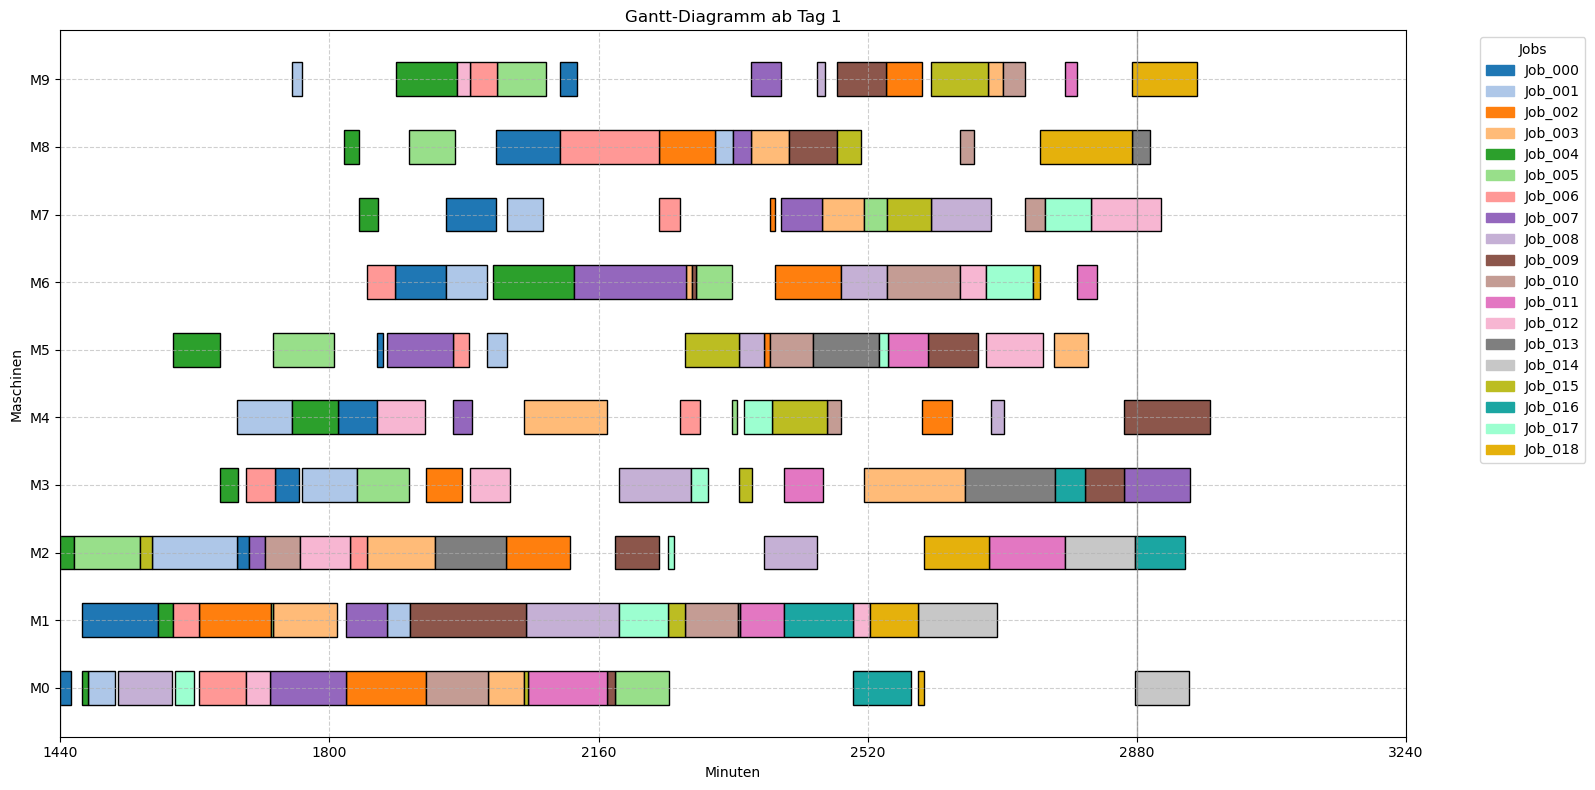

In [30]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

In [31]:
df_plan_undone

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
112,Job_011,7,M7,894,3338,2722,89,2811,-527,0,527
114,Job_011,8,M4,894,3338,2811,26,2837,-501,0,501
127,Job_013,5,M9,1123,3267,2599,72,2671,-596,0,596
125,Job_013,6,M0,1123,3267,2704,47,2751,-516,0,516
132,Job_013,7,M6,1123,3267,2751,65,2816,-451,0,451
130,Job_013,8,M4,1123,3267,2837,6,2843,-424,0,424
134,Job_014,3,M4,1128,3743,2704,99,2803,-940,0,940
138,Job_014,4,M6,1128,3743,2816,9,2825,-918,0,918
135,Job_014,5,M8,1128,3743,2834,52,2886,-857,0,857
150,Job_016,4,M8,1135,3493,2744,90,2834,-659,0,659


In [32]:
undone_numb = len(df_plan_undone)
print(f"Number of undone operations: {undone_numb}")

Number of undone operations: 15


In [33]:
file = file_template.format(text= f"execution_{day_numb:02d}")
file

'data/05_execution_01.csv'

In [34]:
df_execution.to_csv(file, index = False)

In [35]:
file = file_template.format(text= f"plan_{day_numb:02d}_undone")
file

'data/05_plan_01_undone.csv'

In [36]:
df_plan_undone.to_csv(file, index = False)